In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from data_import import (
    load_data, load_ecb_1y_yield,
    fill_liabilities, drop_high_leverage_firms,
    prepare_merton_inputs
)

print(Path.cwd())

c:\Users\afons\OneDrive\Desktop\ESE\FCS\Merton_NIGbayesian


In [33]:
# data loading and initial processing
ret_daily, bs, coverage = load_data(
    Path.cwd() / "Jan2025_Accenture_Dataset_ErasmusCase.xlsx",
    start_date="2012-01-01",
    end_date="2025-12-19",
    enforce_coverage=True,
    coverage_tol=0.95,
    liabilities_scale="auto",
    verbose=True,
)

df_rf = load_ecb_1y_yield(
    startPeriod="2010-01-01",
    endPeriod="2025-12-31",
    out_file="ecb_yc_1y_aaa.xml",
    verify_ssl=True,  # recommended if it works
)

df_cal = ret_daily[["date"]].drop_duplicates().sort_values("date").reset_index(drop=True)

debt_daily = fill_liabilities(bs, df_cal)

ret_filt, bs_filt, lev_by_firm, dropped = drop_high_leverage_firms(
    ret_daily,
    bs,
    df_calendar=df_cal,
    debt_daily=debt_daily,
    lev_threshold=8.0,
    lev_agg="median",
    verbose=True,
)

# keep debt panel consistent with filtered firms
keep = set(ret_filt["gvkey"].astype(str).unique())
debt_daily_filt = debt_daily[debt_daily["gvkey"].astype(str).isin(keep)].copy()

# Merton
merton_df = prepare_merton_inputs(ret_filt, bs_filt, df_rf, debt_daily=debt_daily_filt)

[load_data] Firms (ret_daily): 46
[load_data] Date range (ret_daily): 2012-01-03 .. 2025-12-19
[load_data] Coverage min/median/max: 0.999 / 1.000 / 1.000
[load_data] liabilities_scale_used: 1e+06
[load_data] QA mcap_reported<=0 rows (raw windowed mkt): 62
Data has been written to ecb_yc_1y_aaa.xml
[drop_high_leverage_firms] agg=median, threshold=8.0
[drop_high_leverage_firms] firms before: 46 | after: 36
[drop_high_leverage_firms] dropped firms: 10


In [34]:
# Check missingness of sigma_E
print("Missing sigma_E %:", merton_df["sigma_E"].isna().mean() * 100)
print(merton_df["sigma_E"].describe())

# Check missingness of B and r
print("Missing B %:", merton_df["B"].isna().mean() * 100)
print("Missing r %:", merton_df["r"].isna().mean() * 100)

Missing sigma_E %: 3.431054858754908
count    126655.000000
mean          0.254476
std           0.083942
min           0.117892
25%           0.195147
50%           0.238274
75%           0.292771
max           0.743236
Name: sigma_E, dtype: float64
Missing B %: 0.0
Missing r %: 0.0


In [35]:
# BUILDING THE CALIBRATION DATASET DROPPING ROWS WITH MISSING INPUTS
df = merton_df.copy()

# first date where B becomes available for each firm
first_B_date = (
    df.dropna(subset=["B"])
      .groupby("gvkey")["date"]
      .min()
      .rename("first_B_date")
)
# first date where sigma_E becomes available for each firm
first_sigma_date = (
    df.dropna(subset=["sigma_E"])
      .groupby("gvkey")["date"]
      .min()
      .rename("first_sigma_date")
)

starts = pd.concat([first_B_date, first_sigma_date], axis=1)
starts["calib_start"] = starts[["first_B_date","first_sigma_date"]].max(axis=1)

# attach and filter
df2 = df.merge(starts["calib_start"], on="gvkey", how="left")

calib = (
    df2[df2["date"] >= df2["calib_start"]]
      .dropna(subset=["E","B","r","sigma_E"])
      .query("E > 0 and B > 0")
      .copy()
      .rename(columns={"B":"B_drop"})
)

print("Rows before:", len(df), "Rows after firm-specific start + required inputs:", len(calib))
print("Dropped %:", (len(df)-len(calib))/len(df))
print("Missing values in calibration dataset:")
print(calib.isna().sum())

calib_drop = calib.copy()

Rows before: 131155 Rows after firm-specific start + required inputs: 126655
Dropped %: 0.03431054858754908
Missing values in calibration dataset:
gvkey            0
date             0
E                0
logret_mcap      0
isin             0
company          0
country_iso      0
r                0
B_drop           0
sigma_E_daily    0
sigma_E          0
calib_start      0
dtype: int64


In [36]:
# 5) Rolling settings + one-time preprocessing

from merton_model_afonso import (
    calibrate_sigmaV_window_weekly_merton,
    invert_asset_one_week_merton,
)

from merton_pd_afonso import (
    estimate_mu_from_weekly_implied_assets,
    merton_pd_rn_1y,
    merton_pd_physical_1y,
)

# ----------------------------
# Rolling configuration
# ----------------------------
TRAIN_YEARS = 2
STEP_FREQ = "QE"               # re-estimate every quarter
WEEK_ENDING = "W-FRI"         # weekly points ending on Friday (but we use last trading day in that week)
T_HORIZON = 1.0               # KMV-style horizon for DD/PD
DATA_END = pd.Timestamp("2024-12-31")  # stop at end of dataset
MIN_DAILY_ROWS = 10

# OOS definition: "next quarter"
# We'll run windows where the OOS quarter end is <= DATA_END.
# So the last train_end will be the quarter end immediately before DATA_END.
LAST_TRAIN_END = (DATA_END - pd.offsets.QuarterEnd(1))  # e.g., 2024-09-30

# Debug / runtime control: start small, then scale up.
MAX_FIRMS = None      # e.g. 2 for quick test; None for all firms
MAX_WINDOWS = None # e.g. 2 for quick test; None for all windows


# ----------------------------
# One-time preprocessing for speed
# ----------------------------
panel = merton_df.copy()
panel["gvkey"] = panel["gvkey"].astype(str)
panel["date"] = pd.to_datetime(panel["date"])

# Keep only columns we need repeatedly (reduces memory + speeds groupby slicing)
needed_cols = ["gvkey","date","company","E","B","r","sigma_E"]
panel = panel[[c for c in needed_cols if c in panel.columns]].copy()

# Coerce numeric once (avoid repeating inside loops)
for c in ["E","B","r","sigma_E"]:
    if c in panel.columns:
        panel[c] = pd.to_numeric(panel[c], errors="coerce")

# Add constants once
panel["T"] = float(T_HORIZON)

# Basic cleaning (same spirit as your estimation cell)
panel = (
    panel.dropna(subset=["date","E","B","r","T"])
         .query("E > 0 and B > 0")
         .sort_values(["gvkey","date"])
)

# Build per-firm daily panels once (fast slicing later)
firm_daily = {}
for gvkey, g in panel.groupby("gvkey", sort=False):
    g = g.sort_values("date")
    # dedupe dates if needed
    g = g.groupby("date", as_index=False).last()
    firm_daily[gvkey] = g.set_index("date")

gvkeys_all = sorted(firm_daily.keys())
if MAX_FIRMS is not None:
    gvkeys_all = gvkeys_all[:int(MAX_FIRMS)]

print("Firms loaded:", len(firm_daily), "| Firms in run:", len(gvkeys_all))
print("Panel date range:", panel["date"].min().date(), "to", panel["date"].max().date())
print("LAST_TRAIN_END:", LAST_TRAIN_END.date(), "| DATA_END:", DATA_END.date())

Firms loaded: 36 | Firms in run: 36
Panel date range: 2012-01-03 to 2025-12-19
LAST_TRAIN_END: 2024-09-30 | DATA_END: 2024-12-31


In [37]:
# 6) Build the rolling quarter schedule

global_min_date = panel["date"].min()

# earliest possible train_end is >= (min_date + TRAIN_YEARS - 1 day), aligned to quarter-ends
earliest_end = (global_min_date + pd.DateOffset(years=TRAIN_YEARS) - pd.Timedelta(days=1))

train_ends = pd.date_range(start=earliest_end, end=LAST_TRAIN_END, freq=STEP_FREQ)
train_ends = pd.to_datetime(train_ends)

if MAX_WINDOWS is not None:
    train_ends = train_ends[:int(MAX_WINDOWS)]

windows = []
for train_end in train_ends:
    train_start = train_end - pd.DateOffset(years=TRAIN_YEARS) + pd.Timedelta(days=1)
    oos_start = train_end + pd.Timedelta(days=1)
    oos_end = train_end + pd.offsets.QuarterEnd(1)  # next quarter end

    windows.append({
        "train_start": pd.Timestamp(train_start),
        "train_end": pd.Timestamp(train_end),
        "oos_start": pd.Timestamp(oos_start),
        "oos_end": pd.Timestamp(oos_end),
    })

windows_df = pd.DataFrame(windows)
windows_df

,train_start,train_end,oos_start,oos_end
0,2012-04-01,2014-03-31,2014-04-01,2014-06-30
1,2012-07-01,2014-06-30,2014-07-01,2014-09-30
2,2012-10-01,2014-09-30,2014-10-01,2014-12-31
3,2013-01-01,2014-12-31,2015-01-01,2015-03-31
4,2013-04-01,2015-03-31,2015-04-01,2015-06-30
5,2013-07-01,2015-06-30,2015-07-01,2015-09-30
6,2013-10-01,2015-09-30,2015-10-01,2015-12-31
7,2014-01-01,2015-12-31,2016-01-01,2016-03-31
8,2014-04-01,2016-03-31,2016-04-01,2016-06-30
9,2014-07-01,2016-06-30,2016-07-01,2016-09-30


In [38]:
# 7) Rolling estimation + PDs + OOS inversion (with EXPANDING mu in OOS)

import numpy as np
import pandas as pd
from tqdm import tqdm

def last_trading_day_each_week(df_daily_indexed, week_ending="W-FRI"):
    """
    df_daily_indexed: daily df with DatetimeIndex (trading days)
    Returns a sorted list of actual trading dates representing the last trading day in each W-FRI week.
    """
    if df_daily_indexed.empty:
        return []
    tmp = df_daily_indexed.reset_index().rename(columns={"index": "date"})
    tmp["week"] = tmp["date"].dt.to_period(week_ending)
    wk = tmp.groupby("week")["date"].max().sort_values()
    return wk.tolist()


# Rolling outputs
roll_summary_rows = []      # firm x window (sigma, mu, status)
roll_weekly_is_rows = []    # weekly in-sample (optional but useful)
roll_weekly_oos_rows = []   # weekly OOS (now includes expanding mu + PD_P)

# Warm-start caches
prev_sigma_init = {}  # gvkey -> last sigma_hat
prev_lastV = {}       # gvkey -> last in-sample V_hat

for w in tqdm(windows, desc="Rolling windows"):
    train_start = w["train_start"]
    train_end   = w["train_end"]
    oos_start   = w["oos_start"]
    oos_end     = w["oos_end"]

    for gvkey in gvkeys_all:
        g_all = firm_daily.get(gvkey)
        if g_all is None or g_all.empty:
            roll_summary_rows.append({
                "gvkey": gvkey, "train_end": train_end, "ok": False, "msg": "missing_firm_panel"
            })
            continue

        # ----------------------------
        # Training slice
        # ----------------------------
        g_train = g_all.loc[(g_all.index >= train_start) & (g_all.index <= train_end)].copy()
        if g_train.empty or len(g_train) < MIN_DAILY_ROWS:
            roll_summary_rows.append({
                "gvkey": gvkey, "train_start": train_start, "train_end": train_end,
                "ok": False, "msg": "too_few_daily_rows_train", "n_daily": int(len(g_train))
            })
            continue

        # Add required columns for calibration function (it expects "date" column, not index)
        g_train2 = g_train.reset_index().rename(columns={"index": "date"})
        g_train2["T"] = float(T_HORIZON)

        g_train2 = (
            g_train2.dropna(subset=["date","E","B","r","T"])
                    .query("E > 0 and B > 0")
                    .sort_values("date")
        )

        if len(g_train2) < MIN_DAILY_ROWS:
            roll_summary_rows.append({
                "gvkey": gvkey, "train_start": train_start, "train_end": train_end,
                "ok": False, "msg": "too_few_daily_rows_train_after_clean", "n_daily": int(len(g_train2))
            })
            continue

        # Liability for PD calculation: last available daily point in training window
        B_end = float(g_train2["B"].iloc[-1])

        # Warm start sigma
        sigma_init = prev_sigma_init.get(gvkey, None)

        # ----------------------------
        # Estimate sigma_V + weekly implied assets in-sample
        # ----------------------------
        sigmaV_hat, weekly_df, ok, msg = calibrate_sigmaV_window_weekly_merton(
            g_train2,
            week_ending=WEEK_ENDING,
            ann_factor=52.0,
            sigmaV_init=sigma_init,
            E_col="E",
            B_col="B",
            r_col="r",
            T_col="T",
            sigmaE_col="sigma_E",
        )

        if (not ok) or (weekly_df is None) or (len(weekly_df) == 0) or (not np.isfinite(sigmaV_hat)) or (sigmaV_hat <= 0):
            roll_summary_rows.append({
                "gvkey": gvkey, "train_start": train_start, "train_end": train_end,
                "ok": False, "msg": f"calibration_failed:{msg}", "sigma_hat": sigmaV_hat
            })
            continue

        # store for warm-start next window
        prev_sigma_init[gvkey] = float(sigmaV_hat)

        # ----------------------------
        # In-sample mu and PD at last weekly point
        # ----------------------------
        w_is = weekly_df.copy()
        w_is["date"] = pd.to_datetime(w_is["date"])
        w_is = w_is.sort_values("date")

        # estimate mu from weekly implied assets (training)
        mu_hat = estimate_mu_from_weekly_implied_assets(
            pd.DataFrame({"dlogV": w_is["dlogV"].to_numpy(dtype=float)}),
            float(sigmaV_hat),
            ann_factor=52.0
        )
        mu_hat = float(mu_hat) if np.isfinite(mu_hat) else np.nan

        pd_date = pd.Timestamp(w_is["date"].iloc[-1])
        V_pd = float(w_is["V_hat"].iloc[-1])
        r_pd = float(w_is["r"].iloc[-1])

        PD_Q_1y_is = float(merton_pd_rn_1y(V_pd, B_end, r_pd, float(sigmaV_hat)))
        PD_P_1y_is = float(merton_pd_physical_1y(V_pd, B_end, mu_hat, float(sigmaV_hat))) if np.isfinite(mu_hat) else np.nan

        # store last in-sample V for OOS warm start
        prev_lastV[gvkey] = float(V_pd)

        roll_summary_rows.append({
            "gvkey": gvkey,
            "train_start": train_start, "train_end": train_end,
            "oos_start": oos_start, "oos_end": oos_end,
            "ok": True, "msg": "ok",
            "sigma_hat": float(sigmaV_hat),
            "mu_hat_train": mu_hat,
            "B_end": B_end,
            "pd_date_is": pd_date,
            "PD_Q_1y_is": PD_Q_1y_is,
            "PD_P_1y_is": PD_P_1y_is,
            "n_daily_train": int(len(g_train2)),
            "n_weekly_train": int(len(w_is)),
        })

        # Optional: store weekly in-sample rows (useful for diagnostics)
        w_store = w_is[["date","V_hat","dlogV","r"]].copy()
        w_store["gvkey"] = gvkey
        w_store["train_end"] = train_end
        w_store["sigma_hat"] = float(sigmaV_hat)
        w_store["mu_hat_train"] = mu_hat
        w_store["B_end"] = B_end
        roll_weekly_is_rows.append(w_store)

        # ----------------------------
        # OOS slice + weekly inversion for next quarter
        # ----------------------------
        g_oos = g_all.loc[(g_all.index >= oos_start) & (g_all.index <= oos_end)].copy()
        if g_oos.empty:
            continue

        g_oos = g_oos.dropna(subset=["E","B","r"]).query("E>0 and B>0").copy()
        if g_oos.empty:
            continue

        weekly_dates = last_trading_day_each_week(g_oos, week_ending=WEEK_ENDING)
        if len(weekly_dates) == 0:
            continue

        # --- expanding mu state: start from TRAINING weekly dlogV ---
        train_dlogV = w_is["dlogV"].to_numpy(dtype=float)
        train_dlogV = train_dlogV[np.isfinite(train_dlogV)]
        expanding_dlogV = train_dlogV.tolist()  # will append OOS returns as we go

        # invert week by week
        V_prev = prev_lastV.get(gvkey, None)
        V_prev = float(V_prev) if (V_prev is not None and np.isfinite(V_prev) and V_prev > 0) else None

        oos_rows_this = []
        V_prev_for_dlog = V_prev

        # fast lookup by date
        g_oos_idx = g_oos.groupby(g_oos.index).last()

        for d in weekly_dates:
            if d not in g_oos_idx.index:
                continue
            row = g_oos_idx.loc[d]

            E_obs = float(row["E"])
            B_obs = float(row["B"])
            r_obs = float(row["r"])

            V_hat, d1, d2 = invert_asset_one_week_merton(
                E_obs, B_obs, float(r_obs), float(T_HORIZON), float(sigmaV_hat),
                V_prev=V_prev,
                tol=1e-6,
                maxiter=200
            )

            # compute weekly log-return on implied assets (if we have a previous)
            dlogV = np.nan
            if V_prev_for_dlog is not None and np.isfinite(V_prev_for_dlog) and V_prev_for_dlog > 0 and np.isfinite(V_hat) and V_hat > 0:
                dlogV = float(np.log(V_hat / V_prev_for_dlog))

            # update prevs
            V_prev_for_dlog = V_hat
            V_prev = V_hat

            # --- EXPANDING mu update (no look-ahead): append current dlogV if valid ---
            if np.isfinite(dlogV):
                expanding_dlogV.append(float(dlogV))

            mu_hat_expanding = estimate_mu_from_weekly_implied_assets(
                pd.DataFrame({"dlogV": np.asarray(expanding_dlogV, dtype=float)}),
                float(sigmaV_hat),
                ann_factor=52.0
            )
            mu_hat_expanding = float(mu_hat_expanding) if np.isfinite(mu_hat_expanding) else np.nan

            # PDs at this OOS week
            PD_Q_week = float(merton_pd_rn_1y(float(V_hat), B_obs, r_obs, float(sigmaV_hat)))

            # physical PD with EXPANDING mu (sequential, coherent, no look-ahead)
            PD_P_expandmu_week = (
                float(merton_pd_physical_1y(float(V_hat), B_obs, mu_hat_expanding, float(sigmaV_hat)))
                if np.isfinite(mu_hat_expanding) else np.nan
            )

            oos_rows_this.append({
                "gvkey": gvkey,
                "train_end": train_end,
                "date": pd.Timestamp(d),
                "sigma_hat": float(sigmaV_hat),

                "mu_hat_train": mu_hat,
                "mu_hat_oos_expanding": mu_hat_expanding,

                "E": E_obs,
                "B_used": B_obs,
                "r": r_obs,
                "V_hat_oos": float(V_hat),
                "dlogV_oos": dlogV,

                "PD_Q_1y_oos": PD_Q_week,
                "PD_P_1y_oos": PD_P_expandmu_week,
            })

        if len(oos_rows_this) == 0:
            continue

        oos_df_this = pd.DataFrame(oos_rows_this).sort_values("date").reset_index(drop=True)
        roll_weekly_oos_rows.append(oos_df_this)

# Build final rolling outputs
roll_summary_df = pd.DataFrame(roll_summary_rows).sort_values(["train_end","gvkey"]).reset_index(drop=True)

roll_weekly_is_df = (
    pd.concat(roll_weekly_is_rows, ignore_index=True)
      .sort_values(["train_end","gvkey","date"])
      .reset_index(drop=True)
) if len(roll_weekly_is_rows) else pd.DataFrame()

roll_weekly_oos_df = (
    pd.concat(roll_weekly_oos_rows, ignore_index=True)
      .sort_values(["train_end","gvkey","date"])
      .reset_index(drop=True)
) if len(roll_weekly_oos_rows) else pd.DataFrame()

roll_summary_df, roll_weekly_is_df, roll_weekly_oos_df

Rolling windows: 100%|██████████| 43/43 [03:25<00:00,  4.77s/it]


(       gvkey train_start  train_end  oos_start    oos_end    ok msg  \
 0     100022  2012-04-01 2014-03-31 2014-04-01 2014-06-30  True  ok   
 1     100080  2012-04-01 2014-03-31 2014-04-01 2014-06-30  True  ok   
 2     100312  2012-04-01 2014-03-31 2014-04-01 2014-06-30  True  ok   
 3     100581  2012-04-01 2014-03-31 2014-04-01 2014-06-30  True  ok   
 4     100957  2012-04-01 2014-03-31 2014-04-01 2014-06-30  True  ok   
 ...      ...         ...        ...        ...        ...   ...  ..   
 1543  243774  2022-10-01 2024-09-30 2024-10-01 2024-12-31  True  ok   
 1544  245663  2022-10-01 2024-09-30 2024-10-01 2024-12-31  True  ok   
 1545   24625  2022-10-01 2024-09-30 2024-10-01 2024-12-31  True  ok   
 1546   61214  2022-10-01 2024-09-30 2024-10-01 2024-12-31  True  ok   
 1547   61616  2022-10-01 2024-09-30 2024-10-01 2024-12-31  True  ok   
 
       sigma_hat  mu_hat_train         B_end pd_date_is    PD_Q_1y_is  \
 0      0.079366      0.075953  1.027250e+11 2014-03-31  3.71

In [39]:
# 8) Sanity checks + quick previews

print("roll_summary_df shape:", roll_summary_df.shape)
print("roll_weekly_is_df shape:", roll_weekly_is_df.shape)
print("roll_weekly_oos_df shape:", roll_weekly_oos_df.shape)

# Check that we actually have rolling windows
print("Unique train_end windows:", roll_summary_df["train_end"].nunique() if "train_end" in roll_summary_df.columns else None)

# Basic validity checks
if not roll_summary_df.empty:
    print("Share ok:", roll_summary_df["ok"].mean() if "ok" in roll_summary_df.columns else None)
    print("Sigma summary (ok only):")
    print(roll_summary_df.loc[roll_summary_df["ok"] == True, "sigma_hat"].describe())

# Peek one firm across time
if not roll_summary_df.empty:
    g0 = roll_summary_df.loc[roll_summary_df["ok"] == True, "gvkey"].astype(str).unique()
    if len(g0):
        example = g0[0]
        display(
            roll_summary_df[(roll_summary_df["gvkey"] == example) & (roll_summary_df["ok"] == True)]
            [["gvkey","train_end","sigma_hat","mu_hat_train","PD_Q_1y_is","PD_P_1y_is"]]
            .head(15)
        )

# Peek OOS PDs for same firm
if not roll_weekly_oos_df.empty and len(g0):
    display(
        roll_weekly_oos_df[roll_weekly_oos_df["gvkey"] == example]
        [["gvkey","train_end","date","sigma_hat","PD_Q_1y_oos","PD_P_1y_oos"]]
        .head(30)
    )

roll_summary_df shape: (1548, 15)
roll_weekly_is_df shape: (162396, 9)
roll_weekly_oos_df shape: (21024, 13)
Unique train_end windows: 43
Share ok: 1.0
Sigma summary (ok only):
count    1548.000000
mean        0.163179
std         0.067611
min         0.050427
25%         0.112645
50%         0.152142
75%         0.197465
max         0.436126
Name: sigma_hat, dtype: float64


,gvkey,train_end,sigma_hat,mu_hat_train,PD_Q_1y_is,PD_P_1y_is
0,100022,2014-03-31,0.079366,0.075953,3.715969e-08,1.280220e-10
36,100022,2014-06-30,0.076176,0.100709,7.867343e-09,1.512027e-12
72,100022,2014-09-30,0.077528,0.076145,1.158223e-07,3.493694e-10
108,100022,2014-12-31,0.079295,0.053062,6.213199e-08,1.203138e-09
144,100022,2015-03-31,0.094120,0.146365,4.355041e-07,4.009107e-11
180,100022,2015-06-30,0.097318,0.116888,1.787538e-05,4.137117e-08
216,100022,2015-09-30,0.100160,0.055970,4.092220e-04,4.206887e-05
252,100022,2015-12-31,0.104497,0.080798,6.669232e-05,1.816870e-06
288,100022,2016-03-31,0.123361,0.065403,6.035048e-03,1.036289e-03
324,100022,2016-06-30,0.124684,0.037267,1.962083e-02,7.919808e-03


,gvkey,train_end,date,sigma_hat,PD_Q_1y_oos,PD_P_1y_oos
0,100022,2014-03-31,2014-04-04,0.079366,2.037122e-08,4.803828e-11
1,100022,2014-03-31,2014-04-11,0.079366,5.412197e-08,2.734796e-10
2,100022,2014-03-31,2014-04-18,0.079366,3.262744e-08,1.186320e-10
3,100022,2014-03-31,2014-04-25,0.079366,6.415138e-08,4.094688e-10
4,100022,2014-03-31,2014-05-02,0.079366,7.424729e-08,5.344698e-10
5,100022,2014-03-31,2014-05-09,0.079366,9.465028e-08,8.305762e-10
6,100022,2014-03-31,2014-05-16,0.079366,1.478620e-07,1.797999e-09
7,100022,2014-03-31,2014-05-23,0.079366,6.000773e-08,4.044073e-10
8,100022,2014-03-31,2014-05-30,0.079366,3.343194e-08,1.558185e-10
9,100022,2014-03-31,2014-06-06,0.079366,2.713461e-08,1.135306e-10


In [40]:
# Show in-sample PDs + the exact V and B used (and r) next to them

# last weekly implied asset row in-sample per (train_end, gvkey)
is_last = (
    roll_weekly_is_df.sort_values(["train_end", "gvkey", "date"])
    .groupby(["train_end", "gvkey"], as_index=False)
    .tail(1)
    .rename(columns={"V_hat": "V_used_is", "r": "r_used_is"})
    [["train_end", "gvkey", "V_used_is", "r_used_is"]]
)

insample_view = (
    roll_summary_df
    .merge(is_last, on=["train_end", "gvkey"], how="left")
)

# add percent versions for readability
insample_view["PD_Q_1y_is_pct"] = 100.0 * insample_view["PD_Q_1y_is"]
insample_view["PD_P_1y_is_pct"] = 100.0 * insample_view["PD_P_1y_is"]

cols = [
    "gvkey", "train_end",
    "V_used_is", "B_end", "r_used_is",
    "sigma_hat", "mu_hat_train",
    "PD_Q_1y_is", "PD_Q_1y_is_pct",
    "PD_P_1y_is", "PD_P_1y_is_pct",
]

display(insample_view[cols].sort_values(["gvkey", "train_end"]).head(30))

,gvkey,train_end,V_used_is,B_end,r_used_is,sigma_hat,mu_hat_train,PD_Q_1y_is,PD_Q_1y_is_pct,PD_P_1y_is,PD_P_1y_is_pct
0,100022,2014-03-31,1.577649e+11,1.027250e+11,0.001119,0.079366,0.075953,3.715969e-08,3.715969e-06,1.280220e-10,1.280220e-08
36,100022,2014-06-30,1.584911e+11,1.027250e+11,-0.000091,0.076176,0.100709,7.867343e-09,7.867343e-07,1.512027e-12,1.512027e-10
72,100022,2014-09-30,1.540042e+11,1.027250e+11,-0.000949,0.077528,0.076145,1.158223e-07,1.158223e-05,3.493694e-10,3.493694e-08
108,100022,2014-12-31,1.568591e+11,1.027250e+11,-0.000905,0.079295,0.053062,6.213199e-08,6.213199e-06,1.203138e-09,1.203138e-07
144,100022,2015-03-31,1.877606e+11,1.173660e+11,-0.002487,0.094120,0.146365,4.355041e-07,4.355041e-05,4.009107e-11,4.009107e-09
180,100022,2015-06-30,1.767740e+11,1.173660e+11,-0.002588,0.097318,0.116888,1.787538e-05,1.787538e-03,4.137117e-08,4.137117e-06
216,100022,2015-09-30,1.653727e+11,1.173660e+11,-0.002705,0.100160,0.055970,4.092220e-04,4.092220e-02,4.206887e-05,4.206887e-03
252,100022,2015-12-31,1.766053e+11,1.173660e+11,-0.003968,0.104497,0.080798,6.669232e-05,6.669232e-03,1.816870e-06,1.816870e-04
288,100022,2016-03-31,1.785911e+11,1.294100e+11,-0.004857,0.123361,0.065403,6.035048e-03,6.035048e-01,1.036289e-03,1.036289e-01
324,100022,2016-06-30,1.697460e+11,1.294100e+11,-0.006491,0.124684,0.037267,1.962083e-02,1.962083e+00,7.919808e-03,7.919808e-01


In [41]:
# --- safety: consistent dtypes ---
roll_summary_df = roll_summary_df.copy()
roll_weekly_is_df = roll_weekly_is_df.copy()
roll_weekly_oos_df = roll_weekly_oos_df.copy()

for df_ in [roll_summary_df, roll_weekly_is_df, roll_weekly_oos_df]:
    if "gvkey" in df_.columns:
        df_["gvkey"] = df_["gvkey"].astype(str)
    if "date" in df_.columns:
        df_["date"] = pd.to_datetime(df_["date"])
    if "train_end" in df_.columns:
        df_["train_end"] = pd.to_datetime(df_["train_end"])

# ----------------------------
# 1) TRAINING-END rows
# ----------------------------
is_sorted = roll_weekly_is_df.sort_values(["gvkey", "train_end", "date"])

is_first = (
    is_sorted.groupby(["gvkey", "train_end"], as_index=False)
    .head(1)[["gvkey", "train_end", "V_hat"]]
    .rename(columns={"V_hat": "V_0"})
)

is_last = (
    is_sorted.groupby(["gvkey", "train_end"], as_index=False)
    .tail(1)[["gvkey", "train_end", "date", "V_hat"]]
    .rename(columns={"V_hat": "V_used"})
)

te = (
    roll_summary_df.loc[roll_summary_df["ok"] == True].copy()
    .merge(is_first, on=["gvkey", "train_end"], how="left")
    .merge(is_last,  on=["gvkey", "train_end"], how="left")
)

train_end_rows = pd.DataFrame({
    "gvkey": te["gvkey"].astype(str),
    "date": pd.to_datetime(te["date"]),
    "sigma_hat": te["sigma_hat"].astype(float),
    "mu_hat": te["mu_hat_train"].astype(float),
    "V_0": te["V_0"].astype(float),
    "V_used": te["V_used"].astype(float),
    "B_used": te["B_end"].astype(float),
    "PD_Q": te["PD_Q_1y_is"].astype(float),
    "PD_P": te["PD_P_1y_is"].astype(float),
    "train_end_date": pd.to_datetime(te["train_end"]),   # <-- added
    "training_end": 1,
})

# ----------------------------
# 2) OOS weekly rows
# ----------------------------
required_oos_cols = ["gvkey","date","sigma_hat","mu_hat_oos_expanding","V_hat_oos","B_used","PD_Q_1y_oos","PD_P_1y_oos","train_end"]
missing = [c for c in required_oos_cols if c not in roll_weekly_oos_df.columns]
if missing:
    raise ValueError(f"roll_weekly_oos_df is missing required columns: {missing}")

oos = roll_weekly_oos_df.copy()

oos_rows = pd.DataFrame({
    "gvkey": oos["gvkey"].astype(str),
    "date": pd.to_datetime(oos["date"]),
    "sigma_hat": oos["sigma_hat"].astype(float),
    "mu_hat": oos["mu_hat_oos_expanding"].astype(float),
    "V_0": 0.0,
    "V_used": oos["V_hat_oos"].astype(float),
    "B_used": oos["B_used"].astype(float),
    "PD_Q": oos["PD_Q_1y_oos"].astype(float),
    "PD_P": oos["PD_P_1y_oos"].astype(float),
    "train_end_date": pd.to_datetime(oos["train_end"]),  # <-- added
    "training_end": 0,
})

# ----------------------------
# 3) Combine + resolve conflicts (training_end wins)
# ----------------------------
final_df = pd.concat([train_end_rows, oos_rows], ignore_index=True)

final_df = (
    final_df.sort_values(["gvkey", "date", "training_end"], ascending=[True, True, False])
            .drop_duplicates(subset=["gvkey", "date"], keep="first")
            .sort_values(["gvkey", "date"])
            .reset_index(drop=True)
)

final_df["training_end"] = final_df["training_end"].astype(int)

final_df = final_df[
    ["gvkey","date","sigma_hat","mu_hat","V_0","V_used","B_used","PD_Q","PD_P","train_end_date","training_end"]
]

final_df

,gvkey,date,sigma_hat,mu_hat,V_0,V_used,B_used,PD_Q,PD_P,train_end_date,training_end
0,100022,2014-03-31,0.079366,0.075953,1.363874e+11,1.577649e+11,1.027250e+11,3.715969e-08,1.280220e-10,2014-03-31,1
1,100022,2014-04-04,0.079366,0.079424,0.000000e+00,1.590973e+11,1.027250e+11,2.037122e-08,4.803828e-11,2014-03-31,0
2,100022,2014-04-11,0.079366,0.071941,0.000000e+00,1.569189e+11,1.027250e+11,5.412197e-08,2.734796e-10,2014-03-31,0
3,100022,2014-04-18,0.079366,0.074884,0.000000e+00,1.580810e+11,1.027250e+11,3.262744e-08,1.186320e-10,2014-03-31,0
4,100022,2014-04-25,0.079366,0.069436,0.000000e+00,1.565181e+11,1.027250e+11,6.415138e-08,4.094688e-10,2014-03-31,0
...,...,...,...,...,...,...,...,...,...,...,...
21055,61616,2024-12-06,0.085065,-0.006505,0.000000e+00,1.310894e+11,8.896200e+10,8.966219e-07,4.532528e-06,2024-09-30,0
21056,61616,2024-12-13,0.085065,-0.007816,0.000000e+00,1.306842e+11,8.896200e+10,1.075185e-06,5.758373e-06,2024-09-30,0
21057,61616,2024-12-20,0.085065,-0.014081,0.000000e+00,1.288423e+11,8.896200e+10,2.474818e-06,1.691459e-05,2024-09-30,0
21058,61616,2024-12-27,0.085065,-0.011380,0.000000e+00,1.295835e+11,8.896200e+10,1.773760e-06,1.091966e-05,2024-09-30,0


In [47]:
# save final_df as CSV in the current working directory
final_df.to_csv("final_df.csv", index=False)

# (optional) confirm where it was saved
from pathlib import Path
print("Saved to:", Path.cwd() / "final_df.csv")

Saved to: c:\Users\afons\OneDrive\Desktop\ESE\FCS\Merton_NIGbayesian\final_df.csv


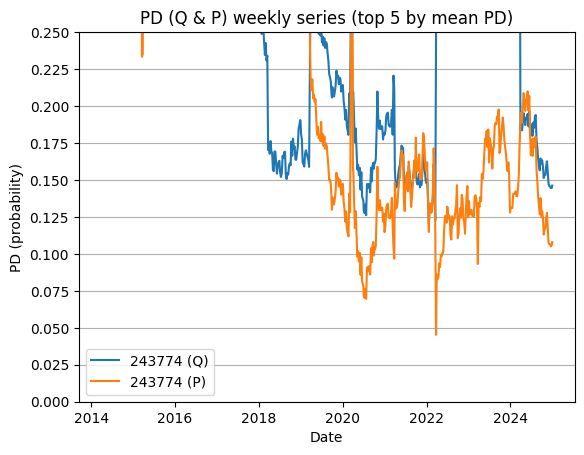

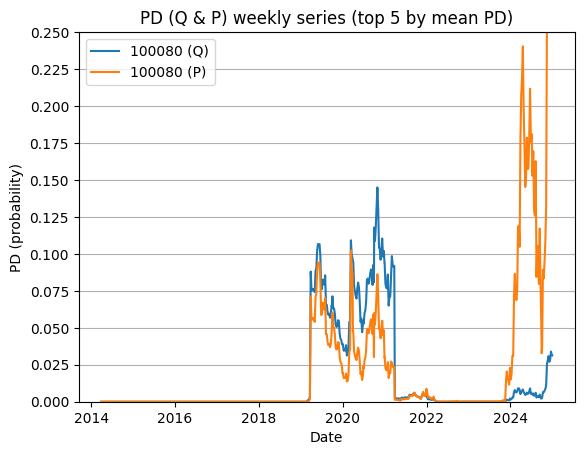

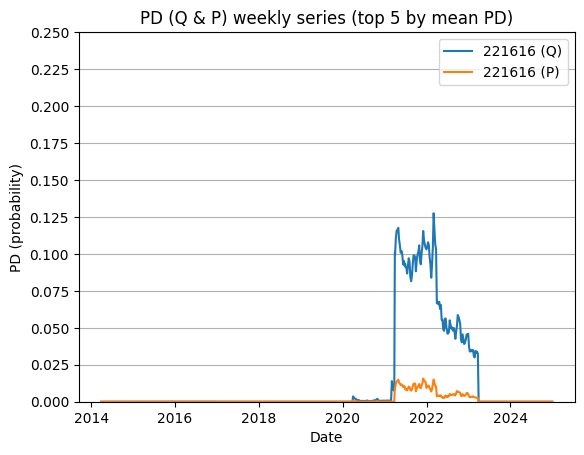

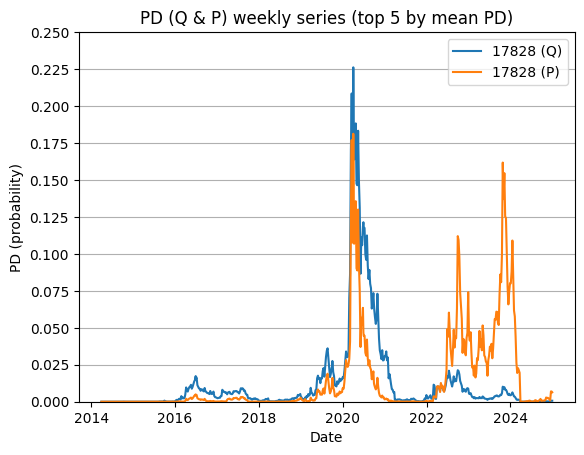

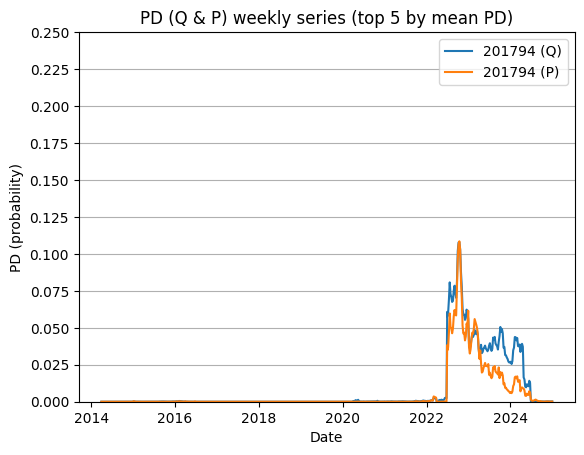

In [ ]:
top_n = 5
top_gv = (
    final_df.groupby("gvkey")["PD_Q"]
    .mean()
    .sort_values(ascending=False)
    .head(top_n)
    .index.tolist()
)

yticks = np.arange(0.0, 1, 0.025)

plt.figure()
for gv in top_gv:
    g = final_df[final_df["gvkey"] == gv].sort_values("date")
    plt.plot(g["date"], g["PD_Q"], label=f"{gv} (Q)")
    plt.plot(g["date"], g["PD_P"], label=f"{gv} (P)")
    plt.ylim(0.0, 0.25)
    plt.yticks(yticks)
    plt.grid(True, axis="y", which="major")

    plt.title(f"PD (Q & P) weekly series (top {top_n} by mean PD)")
    plt.xlabel("Date")
    plt.ylabel("PD (probability)")
    plt.legend()
    plt.show()

